# **Sentiment Analysis  with Neural bag of words (NBoW) also known as CBoW(continous bag of words)**

we will build model to perform sentimen analysis -- a subset of text classification where the task is to detect if a given sentence is positive or negative ---using **pytroch** and **torchtext**

**using imdb dataset(using dataset library)**

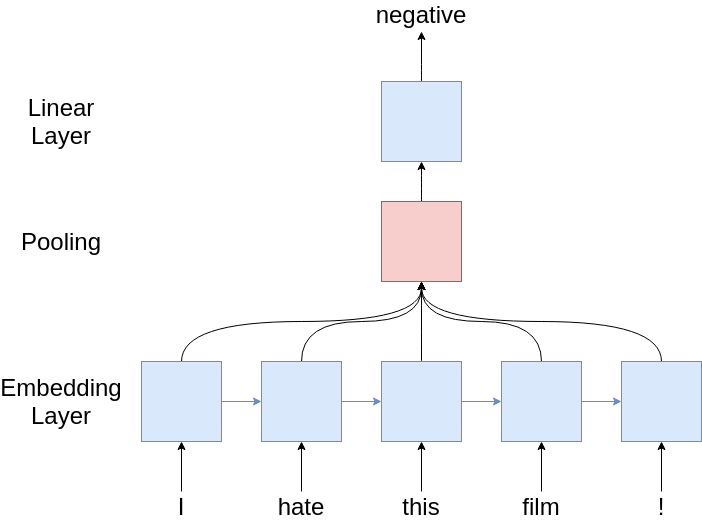

# **WorkFlow**

0. importing important liberaries
1. Preparing Data
2. Build A model
3. 3.Loss Function and Optimizer
4. training And Evaluate Functions
5. Starting Training Loop
6. Visulizing Our Model
7. Testing model ,with new sentence (sentiment analysis)

# **0.Importing Important modules(libraries etc)**

In [ ]:
!pip install datasets

In [ ]:
import collections # need defaultdict from collections so thats why we are using it
import datasets # module getting and handling datasets
import matplotlib.pyplot as plt # plotting our results
import numpy as np # playing with numbers
import torch #playing with tensors
import torch.nn as nn # for neural  networks
import torch.optim as optim #for neural network optimers
import torchtext # for text processing
import tqdm # for making progress bars

# **1 Preparing Data**

in preparing data there are also lot of other steps:<br>
1.1 **Loading Data** <br>
1.2 **Tokenizing data**<br>
1.3 **creating data splits**<br>
1.4 **creating a vocabulary**<br>
1.5 **numericalizing data**<br>
1.6 **converting into tensors**<br>
1.6 **creating the data loader**<br>


# **1.1 Loading the data**

In [ ]:
train_data,test_data=datasets.load_dataset("imdb",split=["train" ,"test"])

1. **first argument(name of the dataset) means, which dataset you want to download**
2. **which data splits yu want**
3. **vist hugging face datasets and imdb for more info**

In [ ]:
train_data,test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

test is a string
2. classlabel means it is intenger representing which class the example belongs ot ,
3. num classes 2 means that ourlabels are one  of two values ,0 and 1 ,and names =['neg , pos].give us the human read able versions of thos valuses

In [ ]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

# **1.2 Tokenize you data or (Tokenization)**

In [ ]:
tokenizer=torchtext.data.utils.get_tokenizer("basic_english")

In [ ]:
tokenizer("Hello world! How are you doing today? i a'm doing fantastic!")

['hello',
 'world',
 '!',
 'how',
 'are',
 'you',
 'doing',
 'today',
 '?',
 'i',
 'a',
 "'",
 'm',
 'doing',
 'fantastic',
 '!']

**notice it creates a token by splitting the word on spaces ,separating punctuation into its own token,and also lowercasing every word**

In [ ]:
def tokenize_example(example,tokenizer,max_length):
  tokens=tokenizer(example["text"])[:max_length]
  return { "tokens" : tokens}

**it returns a dictionary with new feature name and value**

**some sentences are very long , so wee need tokens maximum of maX_Length , but we can predict sentiment with it**

by usng **map** we can apply a function to every **example** in the dataset and either update the example or create a new feature

**The map()** function executes a specified function for each item in an iterable. The item is sent to the function as a parameter.

In [ ]:
max_length=256
train_data=train_data.map(
    tokenize_example,fn_kwargs={"tokenizer": tokenizer,"max_length":max_length}
)
test_data=test_data.map(
    tokenize_example,fn_kwargs={"tokenizer": tokenizer,"max_length":max_length}
)

We apply the **tokenize_example** function below, on both the train and test sets. Any arguments to the function -- that aren't the example -- need to be passed as the **fn_kwargs dictionary**, with the keys being the argument names and the **values** the value passed to that argument.

In [ ]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

**train data has a token feature, as tokens was a key in the dictionary returned by the function we used for the map**

In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

A **length=-1** means that all of our token sequences are not the same length

In [ ]:
train_data[0]["tokens"][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

# **1.3 Creating Validation Data**

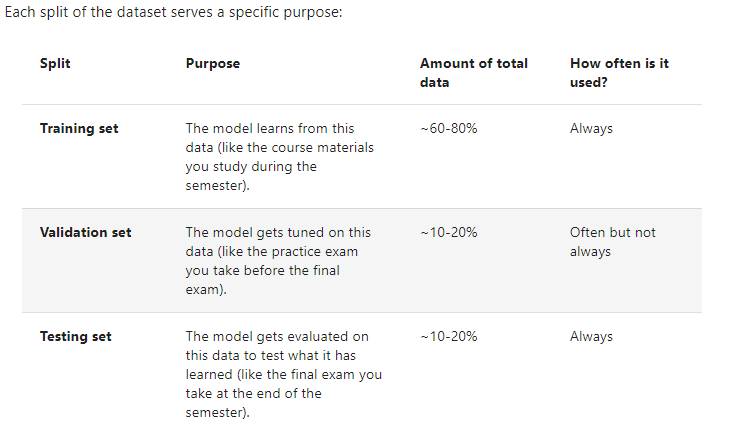

In [ ]:
test_size=0.25
train_valid_data=train_data.train_test_split(test_size=test_size)
train_data=train_valid_data["train"]
valid_data=train_valid_data["test"]

**0.25 means 25% of the training set**

In [ ]:
len(train_data),len(valid_data),len(test_data)

(18750, 6250, 25000)

# **1.4 Creating a Vocabulary**

this is a lookup table where every unique token in yur dataset has corresponding index(integer)

**becuase models need data into numbers**

In [ ]:
min_freq=5
special_tokens=["<unk>","<pad>"]

vocab=torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

we use the **build_vocab_from_iterator** function from **torchtext.vocab** to create our vocabulary,specifying<br>
1. **min_freq**(the minimum amount of times a token should apper to be added to the vocabulary)
2. **special tokens** (tokens which should be appended to the start of the vocabulary ,even if they don't appear min_freq times in the dataset)

**special tokens**<br>
1. **< unk >** : it isour unkown token , it will replace tokens who appear  less than 5 times
2. **< pad >** : use for padding sentences

**why add pad?**<br>
When we feed sentences into our model, we pass a batch of sentences, i.e. more than one, at the same time. Passing a batch of sentences is preferred to passing sentences one at a time as it allows our model to perform computation on all sentences within a batch in paralle, thus speeding up the time taken to train and evaluate our model. All sentences within a batch need to be the same length (in terms of the number of tokens). Thus, to ensure each sentence is the same length, any shorter than the longest sentence need to have padding tokens appended to the end of them.

In [ ]:
len(vocab)

21550

We can view the tokens in our vocabulary using the **get_itos**(**integer to string**) method, which returns a** list of strings (tokens)**, and the **index of each token** in the list is the index of the token in our vocabulary.

In [ ]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [ ]:
vocab["and"]

6

We store the indices of the unknown and padding tokens (zero and one, respectively) in variables, as we'll use these further on in this notebook.

In [ ]:
unk_index=vocab["<unk>"]
pad_index=vocab["<pad>"]

We can check if a token is in our vocabulary using the **in** operator.

In [ ]:
"some_token" in vocab

False

By default, a vocabulary created by torchtext will throw an error if you attempt to obtain the index of a token which is not in the vocabulary, i.e. vocab["some_token"] will throw an error.

In [ ]:
vocab["some_token"]

We need to explicity tell the vocabulary which token to return if we pass a token not in the vocabulary. We do this using the **set_default_index** method, passing in the index we wish it to return. Here, we pass the index of the unknown token.

In [ ]:
vocab.set_default_index(unk_index)

Now, when trying to get the index of a token that is not in the vocabulary, instead of throwing an error we get zero, the value of unk_index, our unknown token, **< unk >**.

In [ ]:
vocab["some_token"]

0

To look-up a list of tokens, we can use the vocabulary's **lookup_indices** method.

In [ ]:
vocab.lookup_indices(["hello","world","some_token","<pad>"])

[5256, 188, 0, 1]

# **1.5 Numericalizing Our Data**

Now we have our vocabulary, we can numericalize our data. This involves converting the tokens within our dataset into indices. Similar to how we tokenized our data using the **Dataset.map** method, we'll define a function that takes an example and our vocabulary, gets the index for each token in each example and then creates an ids field which containes the numericalized tokens.

In [ ]:
def numericalize_example(example,vocab):
  ids=vocab.lookup_indices(example["tokens"])
  return { "ids" : ids}

We then apply this function to all examples in the training, validation and testing datasets.

In [ ]:
train_data=train_data.map(numericalize_example,fn_kwargs={"vocab":vocab})
valid_data=valid_data.map(numericalize_example,fn_kwargs={"vocab":vocab})
test_data=test_data.map(numericalize_example,fn_kwargs={"vocab":vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'ids'],
    num_rows: 18750
})

In [ ]:
train_data[0]["tokens"][:10]

['an',
 'excellent',
 'and',
 'accurate',
 'film',
 '.',
 '.',
 '.',
 'mcgovern',
 'takes']

Checking an example, we can see that the id field now consists of the indexes of the tokens from that example.

In [ ]:
vocab.lookup_indices(train_data[0]["tokens"][:10])

[42, 302, 6, 1624, 23, 3, 3, 3, 13656, 317]

In [ ]:
train_data[0]['ids'][:10]

[42, 302, 6, 1624, 23, 3, 3, 3, 13656, 317]

# **1.6 Converting into tensors**

The final step of numericalization is transforming the ids and label from integers into PyTorch tensors, which we do using the with_format method.

We do this because our PyTorch models work with tensors, and not integers.

In [ ]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'ids'],
    num_rows: 18750
})

In [ ]:
train_data=train_data.with_format(type="torch",columns=["ids","label"])
valid_data=valid_data.with_format(type="torch",columns=["ids","label"])
test_data=test_data.with_format(type="torch",columns=["ids","label"])

In [ ]:
train_data[0]["label"]

tensor(1)

In [ ]:
train_data[0]["ids"][:10]

tensor([   42,   302,     6,  1624,    23,     3,     3,     3, 13656,   317])

One thing to note is that when using **with_format**, all the columns not specified ("**tokens**" and "**text**") are removed from the example.

In [ ]:
train_data[0].keys()

dict_keys(['label', 'ids'])

Removing the "tokens" field is fine, as if we wanted to retrieve the human-readable tokens again we can simply convert the tensor into a Python list of integers and then use the vocabulary's **lookup_tokens** method.

In [ ]:
vocab.lookup_tokens(train_data[0]["ids"][:10].tolist())

['an',
 'excellent',
 'and',
 'accurate',
 'film',
 '.',
 '.',
 '.',
 'mcgovern',
 'takes']

# **1.7 Creating Data Loaders**

The final step of preparing the data is creating the data loaders. We can iterate over a data loader to retrieve batches of examples. This is also where we will perform **any padding that is necessary**.

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn


1. Here, our desired output from the data loader is a dictionary with keys of "**ids**" and "**label**".

2. The value of **batch["ids"]** should be a tensor of shape **[batch size, length]**, where **length** is the length of the longest sentence (in terms of tokens) within the batch, and **all sentences shorter than this should be padded to that length.**

3. The value of **batch["label"]** should be a tensor of **shape [batch size]** consisting of the label for each sentence in the batch

1. We define a function, **get_collate_fn**, which is passed the pad token index and returns the actual collate function.
2.  Within the **actual collate function**, **collate_fn**, we get a **list of "ids"** tensors for each example in the batch, and then use the **pad_sequence **function, which converts the list of tensors into the desired **[batch size, length]** shaped tensor and performs padding using the specified **pad_index**. 3. By default, pad_sequence will return a **[length, batch size]** shaped tensor, but by setting **batch_first=True**, these two dimensions are switched. We get a list of "label" tensors and convert the list of tensors into a single **[batch size]** shaped tensor.

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader


Next, **we define a function which returns our actual data loader**. It takes in a dataset, desired batch size (the number of sentences we want in a batch), our padding token index, and if the dataset should be shuffled.

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


Finally, we get the data loaders for the training, validation and test data.

We set the batch size equal to 512. Our batch size should be set as high as we can, as larger batches means more parallel computation, less compute time, and thus faster training and evaluation.

Only the training data loader needs to be shuffled, as it's the only one used to actually tune the parameters within the model, and your training data should always be shuffled.

In [ ]:
len(train_data_loader)

37

# **2. Build the Model**

In [ ]:
class NBoW(nn.Module):
  def __init__(self,vocab_size,embedding_dim,output_dim,pad_index):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=pad_index)
    self.fc=nn.Linear(embedding_dim,output_dim)

  def forward(self,ids):
    #ids = [Batch size , seq len]
    embedded=self.embedding(ids)
    #embedded=[batch size,seq len , embedding dim]
    pooled=embedded.mean(dim=1)
    #pooled = [batch size ,embedding dim]
    prediction=self.fc(pooled)
    #prediction = [batch size ,output dim]
    return prediction


In [ ]:
vocab_size=len(vocab)
embedding_dim=300
output_dim=len(train_data.unique("label"))
model=NBoW(vocab_size,embedding_dim,output_dim,pad_index)

In [ ]:
len(vocab)

21550

In [ ]:
len(train_data.unique("label"))

2

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"the model has { count_parameters(model):,} trainable parameters")

the model has 6,465,602 trainable parameters


In [ ]:
vectors=torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [06:05<00:00, 6013.83it/s]


In [ ]:
hello_vector=vectors.get_vecs_by_tokens("hello")

In [ ]:
hello_vector.shape

torch.Size([300])

In [ ]:
hello_vector[:32]

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [ ]:
pretrained_embedding=vectors.get_vecs_by_tokens(vocab.get_itos())

In [ ]:
pretrained_embedding.shape

torch.Size([21550, 300])

In [ ]:
model.embedding.weight

Parameter containing:
tensor([[-1.3056,  0.9889, -0.4164,  ...,  1.0188,  1.7216,  2.1897],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2659,  2.1271,  0.8047,  ...,  0.7559,  0.7197,  0.7403],
        ...,
        [-1.3947,  0.2654,  1.4428,  ..., -0.0318, -0.5026,  1.6228],
        [ 2.5107, -1.5741,  0.4244,  ...,  1.3890,  0.1927, -1.0740],
        [ 0.3918, -0.8089,  0.6667,  ...,  2.0093,  0.3645, -1.3529]],
       requires_grad=True)

In [ ]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1349,  0.1143,  0.2112,  ...,  0.3040, -0.6853,  0.2070],
        [-0.1503,  0.5624, -0.5622,  ..., -0.4224, -0.6836,  0.0726]])

In [ ]:
model.embedding.weight.data=pretrained_embedding

In [ ]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1349,  0.1143,  0.2112,  ...,  0.3040, -0.6853,  0.2070],
        [-0.1503,  0.5624, -0.5622,  ..., -0.4224, -0.6836,  0.0726]],
       requires_grad=True)

# **3.Loss Function and Optimizer**

In [ ]:
optimizer=optim.Adam(model.parameters())

In [ ]:
criterion=nn.CrossEntropyLoss()

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model=model.to(device)
criterion=criterion.to(device)

# **4. training And Evaluate Functions**

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


In [ ]:
def evaluate(data_loader,model,criterion,device):
  model.eval()
  epoch_losses=[]
  epoch_accs=[]
  with torch.no_grad():
    for batch in tqdm.tqdm(data_loader,desc="evaluating..."):
        ids=batch["ids"].to(device)
        label=batch["label"].to(device)
        prediction=model(ids)
        loss=criterion(prediction,label)
        accuracy=get_accuracy(prediction,label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
  return np.mean(epoch_losses),np.mean(epoch_accs)


In [ ]:
def get_accuracy(prediction,label):
  batch_size,_=prediction.shape
  predicted_classes=prediction.argmax(dim=-1)
  correct_prediction=predicted_classes.eq(label).sum()
  accuracy=correct_prediction / batch_size
  return accuracy

# **5. Starting Training Loop**

The **defaultdict** in Python is a container defined in the collections module. It is a subclass of the built-in dict class and provides a default value for the key that does not exist. This means that if a key is not found in the dictionary, instead of a KeyError being thrown, a new key is created with the default value

In [ ]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


epoch: 0
train_loss: 0.637, train_acc: 0.737
valid_loss: 0.610, valid_acc: 0.744


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


epoch: 1
train_loss: 0.573, train_acc: 0.773
valid_loss: 0.544, valid_acc: 0.787


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


epoch: 2
train_loss: 0.500, train_acc: 0.818
valid_loss: 0.481, valid_acc: 0.823


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


epoch: 3
train_loss: 0.433, train_acc: 0.852
valid_loss: 0.432, valid_acc: 0.837


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


epoch: 4
train_loss: 0.379, train_acc: 0.873
valid_loss: 0.395, valid_acc: 0.850


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


epoch: 5
train_loss: 0.338, train_acc: 0.888
valid_loss: 0.370, valid_acc: 0.858


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


epoch: 6
train_loss: 0.305, train_acc: 0.899
valid_loss: 0.351, valid_acc: 0.863


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


epoch: 7
train_loss: 0.279, train_acc: 0.908
valid_loss: 0.336, valid_acc: 0.865


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


epoch: 8
train_loss: 0.257, train_acc: 0.916
valid_loss: 0.325, valid_acc: 0.869


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


epoch: 9
train_loss: 0.238, train_acc: 0.924
valid_loss: 0.318, valid_acc: 0.869


# **6.Visulizing Our Model**

**visulze training loss and val loss**

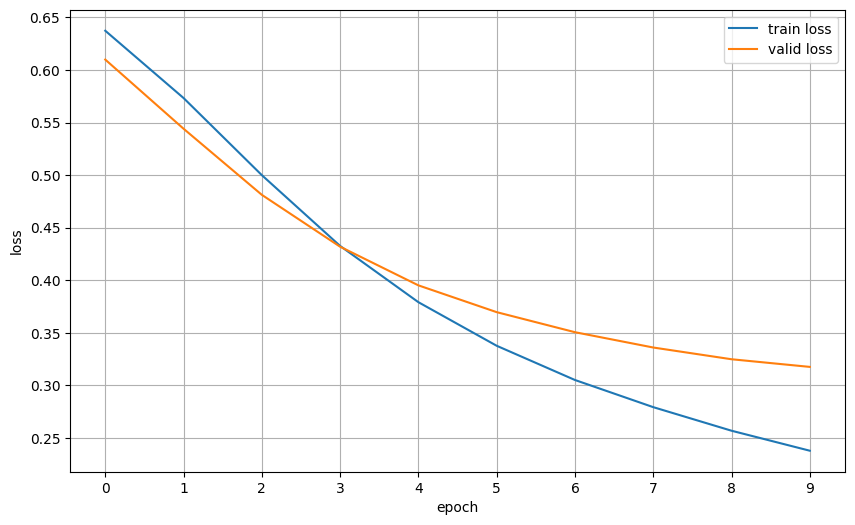

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

**visulizing train accuray and valid accuracy**

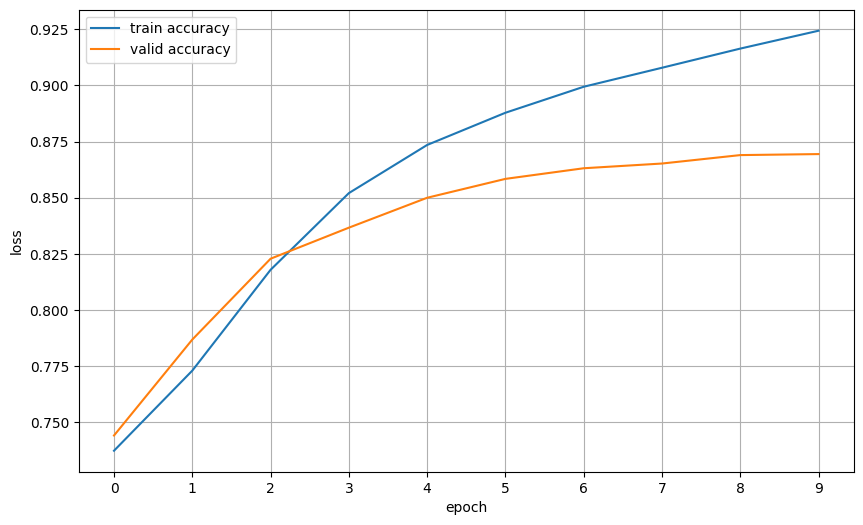

In [ ]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(metrics["train_accs"],label="train accuracy")
ax.plot(metrics["valid_accs"],label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

# **again loading state_dict()**

In [ ]:
model.load_state_dict(torch.load("nbow.pt"))
test_loss,test_acc=evaluate(test_data_loader,model,criterion,device)

evaluating...: 100%|██████████| 49/49 [00:11<00:00,  4.38it/s]


In [ ]:
print(f"test_loss: {test_loss:.3f},test_acc: {test_acc:.3f}")

test_loss: 0.350,test_acc: 0.856


# **7. Testing model ,with new sentence (sentiment analysis)**

In [ ]:
def predict_sentiment(text,model,tokenizer,vocab,device):
  tokens=tokenizer(text)
  ids=vocab.lookup_indices(tokens)
  tensor=torch.LongTensor(ids).unsqueeze(dim=0).to(device)
  prediction=model(tensor).squeeze(dim=0)
  probability=torch.softmax(prediction,dim=-1)
  predicted_class=prediction.argmax(dim=-1).item()
  predicted_probability=probability[predicted_class].item()
  return predicted_class,predicted_probability


In [ ]:
text="this film is terrible!"
predict_sentiment(text,model,tokenizer,vocab,device)

(0, 0.9999986886978149)

In [ ]:
text="this film is great!"
predict_sentiment(text,model,tokenizer,vocab,device)

(1, 0.9999998807907104)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.7102710008621216)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.7102710008621216)